# EDA del dataset Sales Multistore completo preprocesado

## 1. Importación de librerías y de datos

In [1]:
import pandas as pd
import numpy as np
from decimal import Decimal
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
from collections import defaultdict
import math
import json


# Date time conversion registration
from pandas.plotting import register_matplotlib_converters

In [73]:
# Configuraciones de Pandas, Numpy, Decimal, etc.

# Pandas
pd.options.mode.chained_assignment = None

# Matplotlib
register_matplotlib_converters()

# Seaborn
sns.set(font_scale=1.5)
# sns.set(rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'}, font_scale=1.5)
sns.set_style("ticks")

In [3]:
pd_sales_multistore = pd.read_csv('sales_multistore_10_2019_04_2020_v2.csv')

## 2. Análisis de la estructura

In [4]:
pd_sales_multistore.head(10)

,event_time,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:02:14+00:00,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564
1,2019-10-01 00:04:37+00:00,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68
2,2019-10-01 00:07:07+00:00,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f
3,2019-10-01 00:09:26+00:00,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553
4,2019-10-01 00:09:54+00:00,4804056,2053013554658804075,electronics.audio.headphone,apple,161.98,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68
5,2019-10-01 00:10:08+00:00,1002524,2053013555631882655,electronics.smartphone,apple,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238
6,2019-10-01 00:10:56+00:00,6200687,2053013552293216471,appliances.environment.air_heater,oasis,28.03,548691404,b67cdbcb-b073-4271-b365-803c6fce53b0
7,2019-10-01 00:12:14+00:00,4802036,2053013554658804075,electronics.audio.headphone,apple,171.56,533624186,e5ac3caa-e6d5-4d6b-ae06-2c18cd9ca683
8,2019-10-01 00:14:14+00:00,1004932,2053013555631882655,electronics.smartphone,vivo,463.31,555083442,83d12d1a-5452-4fa0-abbb-d9f492f8b562
9,2019-10-01 02:19:10+00:00,1004246,2053013555631882655,electronics.smartphone,apple,736.18,515246296,b7dbae4f-cad3-463e-89ce-41990cf48dea


In [5]:
pd_sales_multistore.shape

(5707926, 8)

In [6]:
pd_sales_multistore.dtypes

event_time        object
product_id         int64
category_id        int64
category_code     object
brand             object
price            float64
user_id            int64
user_session      object
dtype: object

In [7]:
pd_sales_multistore.columns

Index(['event_time', 'product_id', 'category_id', 'category_code', 'brand',
       'price', 'user_id', 'user_session'],
      dtype='object')

In [8]:
# Cambio el tipo de datos de algunas columnas
# Los tipos de datos más eficiente a efectos de manejo de memoria son los numéricos int
# Cambio a int las columnas que tienen valores numéricos, aunque no vaya a hacer operaciones
# con estos valores.
# Una excepción es 'price'. Quiero que tenga precisión decimal (no de float), pero
# curiosamente para convertir a este tipo hay que partir de string, no de float.
# Cambiar object por category cuando se trata de variables categóricas es más eficiente
# También cambio la variable 'event_time' a datetime, para poder hacer cálculos de fechas
pd_sales_multistore = pd_sales_multistore.astype({"product_id":'int32', "category_id":'int64', \
                                                   "category_code":'category', "brand":'category', \
                                                   "price":'string', "user_session":'string'})
pd_sales_multistore['event_time'] = pd.to_datetime(pd_sales_multistore['event_time'])

In [9]:
pd_sales_multistore.dtypes

event_time       datetime64[ns, UTC]
product_id                     int32
category_id                    int64
category_code               category
brand                       category
price                         string
user_id                        int64
user_session                  string
dtype: object

### 2.1 Variables numéricas

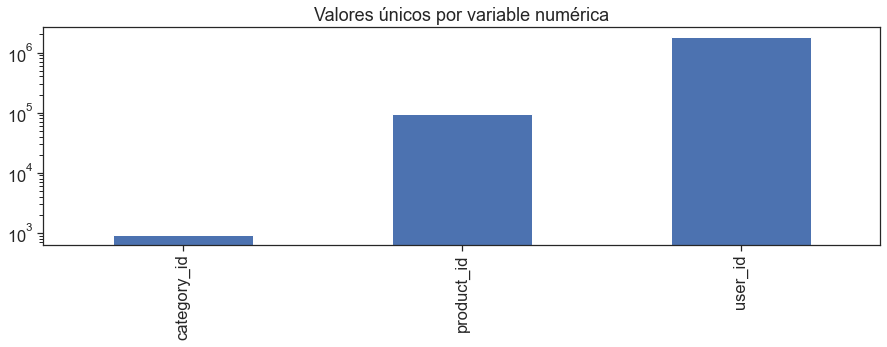

In [11]:
# Valores únicos de cada variable numérica, ordenadas
pd_sales_multistore_unique = pd_sales_multistore.select_dtypes(include="number").nunique().sort_values()

# Ploteo con escala logarítmica en el eje y
pd_sales_multistore_unique.plot.bar(logy=True, figsize=(15, 4), title="Valores únicos por variable numérica")
plt.show()

Todo parece lógico: hay menos categorías (category_id) que productos (product_id) y más usuarios (user_id) que productos y categorías.

In [12]:
# referencias distintas que aparecen en el dataset
pd_sales_multistore['product_id'].nunique()

96037

### 2.2 Variables no numéricas

In [13]:
# Valores únicos de cada variable no numérica, ordenadas. 'price' aparece como variable no numérica,
# porque lo he convertido a string como paso previo para convertirlo en decimal.
pd_sales_multistore.describe(exclude="number", datetime_is_numeric=True)

,event_time,category_code,brand,price,user_session
count,5707926,5707926,5707926,5707926,5707923
unique,NaN,139,4081,67748,4544395
top,NaN,construction.tools.light,samsung,128.42,12ec3547-84f2-4eab-bd64-725ddc03dd5b
freq,NaN,2309625,1563759,28090,403
mean,2020-01-23 02:08:21.779728640+00:00,NaN,NaN,NaN,NaN
min,2019-10-01 00:02:14+00:00,NaN,NaN,NaN,NaN
25%,2019-12-10 12:09:34.500000+00:00,NaN,NaN,NaN,NaN
50%,2020-01-27 16:41:30+00:00,NaN,NaN,NaN,NaN
75%,2020-03-08 02:34:04.750000128+00:00,NaN,NaN,NaN,NaN
max,2020-04-30 23:59:36+00:00,NaN,NaN,NaN,NaN


## 3. Calidad de los datos

### 3.1 Filas duplicadas

In [14]:
# Ignoramos el índice, que hace que las filas sean distintas
pd_sales_multistore[pd_sales_multistore.duplicated()]

,event_time,product_id,category_id,category_code,brand,price,user_id,user_session
3310,2019-10-01 06:41:39+00:00,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,555119233,53ad00ec-2d13-491c-9743-504913ea238c
9555,2019-10-01 12:42:40+00:00,1004767,2053013555631882655,electronics.smartphone,samsung,254.19,512386086,4a1f199d-e77b-4ff7-8807-47b31c1b6aca
49420,2019-10-04 07:20:16+00:00,5700758,2053013553970938175,auto.accessories.player,pioneer,75.94,517161433,80109315-6ff2-4b59-adec-f99cd75efb81
67687,2019-10-05 05:34:08+00:00,1004856,2053013555631882655,electronics.smartphone,samsung,131.92,535394720,af308845-2f01-43c0-a441-d70814450de6
79698,2019-10-05 16:37:05+00:00,1801690,2053013554415534427,electronics.video.tv,samsung,370.53,539724704,352cbf09-0d93-4086-9395-49605f75c59f
...,...,...,...,...,...,...,...,...
5297185,2020-04-16 17:00:09+00:00,24100688,2232732100954423843,appliances.personal.massager,kerasys,6.56,635946366,252d0d1f-23d9-4a36-bafd-82416840a9d1
5550832,2020-04-26 08:45:24+00:00,1002540,2232732093077520756,construction.tools.light,apple,409.78,515172019,5e8a156d-c481-4017-a550-63d4ba6ecaf8
5642867,2020-04-29 04:16:34+00:00,8800895,2053013560530830019,electronics.camera.video,bq,19.79,643856840,aa10f9d5-3275-4390-8b29-1e408b286f89
5666683,2020-04-29 15:33:22+00:00,1005169,2232732093077520756,construction.tools.light,samsung,180.42,648354166,2927cd4d-3a2a-4853-be26-f5139eff973f


¡Son muchas filas duplicadas! Espero que no haya ningún error en mi comando. Hago una comprobación y utilizo para ello el valor 'user_session' de la fila 3310 de arriba.

In [15]:
# No me deja hacer una AND de la 'product_id' y la 'user_session'. Al parecer tiene que ser el mismo tipo
# de datos
pd_sales_multistore.loc[pd_sales_multistore['user_session'] == '53ad00ec-2d13-491c-9743-504913ea238c']

,event_time,product_id,category_id,category_code,brand,price,user_id,user_session
3309,2019-10-01 06:41:39+00:00,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,555119233,53ad00ec-2d13-491c-9743-504913ea238c
3310,2019-10-01 06:41:39+00:00,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,555119233,53ad00ec-2d13-491c-9743-504913ea238c
3334,2019-10-01 06:43:02+00:00,1004750,2053013555631882655,electronics.smartphone,samsung,203.35,555119233,53ad00ec-2d13-491c-9743-504913ea238c


¡Realmente están duplicadas! Elimino las filas duplicadas.

In [16]:
pd_sales_multistore.drop_duplicates(inplace=True)
pd_sales_multistore.shape

(5573721, 8)

### 3.2 Valores faltantes

Aunque ya se hizo una limpieza de valores faltantes durante el preprocesamiento de los archivos originales, no está de más hacer una nueva comprobación.

In [17]:
pd_sales_multistore.isna().sum()

event_time       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     3
dtype: int64

In [18]:
pd_sales_multistore[pd_sales_multistore.isna().any(axis=1)]

,event_time,product_id,category_id,category_code,brand,price,user_id,user_session
5294675,2020-04-16 15:39:34+00:00,5000313,2232732102950912587,appliances.sewing_machine,brother,175.81,563939005,<NA>
5370972,2020-04-18 19:37:11+00:00,1005098,2232732093077520756,construction.tools.light,samsung,146.46,643633435,<NA>
5581259,2020-04-27 07:18:28+00:00,2800477,2232732091307524418,appliances.kitchen.refrigerators,beko,422.12,514665829,<NA>


In [19]:
# Eliminamos estas filas con nulos
pd_sales_multistore.dropna(inplace=True)

In [20]:
pd_sales_multistore[pd_sales_multistore.isna().any(axis=1)]

,event_time,product_id,category_id,category_code,brand,price,user_id,user_session


### 3.3 Otro tipo de errores en los datos

In [21]:
# Estadística de variables categóricas
pd_sales_multistore.describe(include=['category'], datetime_is_numeric=True)

,category_code,brand
count,5573718,5573718
unique,139,4081
top,construction.tools.light,samsung
freq,2232975,1527193


In [22]:
# Hay fechas fuera de rango?
print('Fecha inicial: {}, Fecha final: {}'.format(pd_sales_multistore['event_time'].min(), pd_sales_multistore['event_time'].max()))

Fecha inicial: 2019-10-01 00:02:14+00:00, Fecha final: 2020-04-30 23:59:36+00:00


In [23]:
# Convierto los valores de 'price' a decimal
pd_sales_multistore['price'] = pd_sales_multistore['price'].apply(Decimal)
# pd_sales_multistore['price'] = pd_sales_multistore['price'].apply(lambda x: round(x, 2))

In [24]:
print('Precio más bajo: {}, Precio más alto: {}'.format(pd_sales_multistore['price'].min(), pd_sales_multistore['price'].max()))

Precio más bajo: 0.2, Precio más alto: 2574.07


Otro chequeo que podemos hacer de los precios es si siguen una evolución normal.
Averiguo cuáles son las referencias más vendidas, para utilizar valores representativos

In [25]:
# La referencia '1004767' es de las más vendidas (ver en el apdo. 5.1). Cuál es su precio mínimo y máximo dentro de la serie temporal?
print('Precio mínimo: {}'.format(pd_sales_multistore[pd_sales_multistore['product_id'] == 1004767]['price'].min()))
print('Precio máximo: {}'.format(pd_sales_multistore[pd_sales_multistore['product_id'] == 1004767]['price'].max()))

Precio mínimo: 223.92
Precio máximo: 308.89


In [26]:
# Es una diferencia considerable
print('Diferencia entre el precio más alto y el más bajo: {}%'.format( round((Decimal(308.89)-Decimal(223.92))/Decimal(223.92)*100,2)))

Diferencia entre el precio más alto y el más bajo: 37.95%


Ploteo la evolución del precio de esta referencia. El problema es que no puedo plotear un valor decimal. Tengo que convertirlo primero a float.

In [27]:
pd_sales_multistore_1004767 = pd_sales_multistore[pd_sales_multistore['product_id'] == 1004767]
pd_sales_multistore_1004767['price'] = pd_sales_multistore_1004767['price'].astype(float)

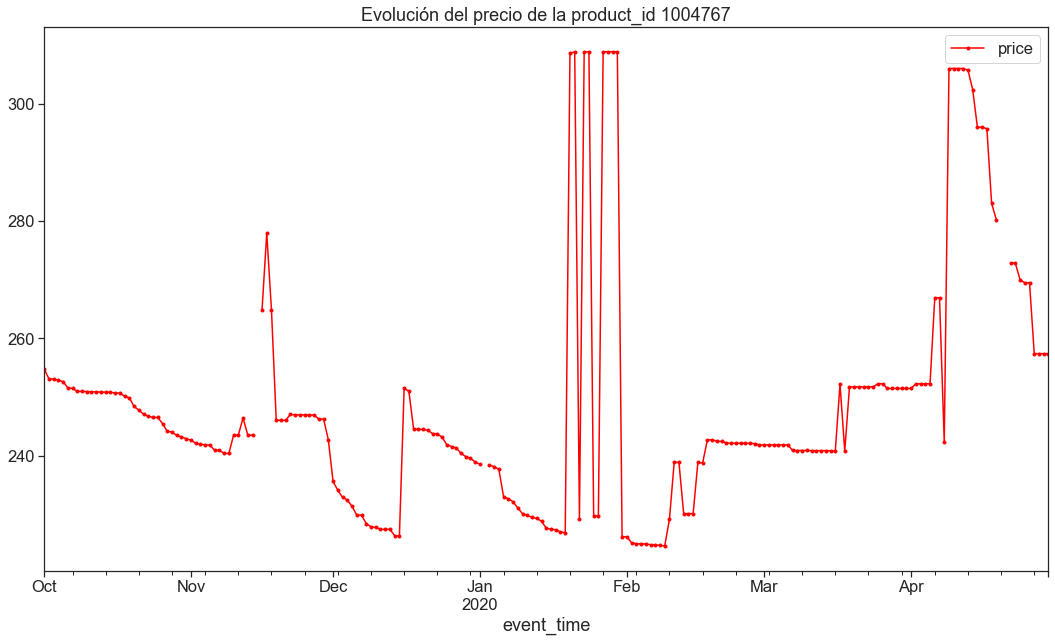

In [28]:
pd_sales_multistore_1004767_plot = pd_sales_multistore_1004767.set_index('event_time')['price'].resample('D').max().to_frame() \
.reset_index()
pd_sales_multistore_1004767_plot.plot(figsize=(18,10), x='event_time', y='price', c='red', marker='.', \
title='Evolución del precio de la product_id 1004767')
plt.show()

Las discontinuidades de la gráfica se deben a que hay días en que no se ha producido venta de la referencia analizada. Pero, aparte de esto, el precio de esta referencia pega unos bandazos enormes. **¿Por qué?**

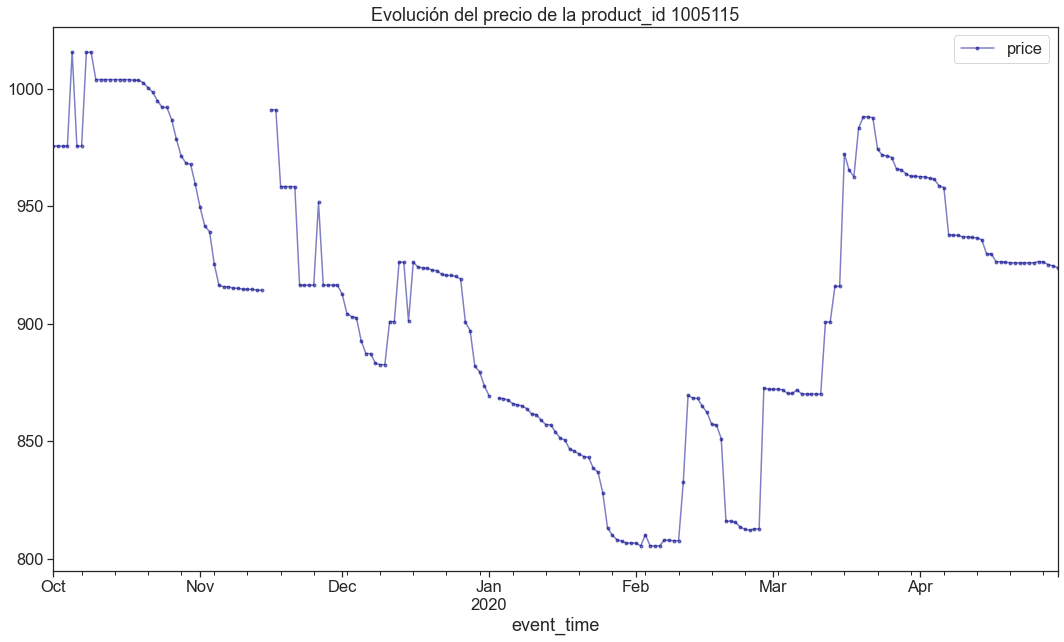

In [29]:
# Otra de las referencias más vendidos: 1005115
pd_sales_multistore_1005115 = pd_sales_multistore[pd_sales_multistore['product_id'] == 1005115]
pd_sales_multistore_1005115['price'] = pd_sales_multistore_1005115['price'].astype(float)
pd_sales_multistore_1005115_plot = pd_sales_multistore_1005115.set_index('event_time')['price'].resample('D').max().to_frame() \
.reset_index()
pd_sales_multistore_1005115_plot.plot(figsize=(18,10), x='event_time', y='price', c='darkblue', alpha=0.5, marker='.', \
title='Evolución del precio de la product_id 1005115')
plt.show()

¡También pega unos bandazos enormes! Vamos a averiguar por qué.

In [30]:
# Trato de averiguar un máximo común divisor de los precios de esta product_id, por si los precios que
# aparecen fuera múltiplos de un precio unitario, con lo cual cambiaría todo el planteamiento del 
# análisis, porque cada entrada del dataframe no se referiría ya a 1 unidad vendida.
np.gcd.reduce(pd_sales_multistore_1005115['price'].astype('int').to_numpy())

1

El MCD es 1, con lo cual NO hay MCD y entiendo que son precios unitarios. En caso de utilizar estos precios
habría que decir qué hacemos con ellos para "estabilizarlos" (aplicar la media o la mediana).

## 4. Parseado de categorías

In [31]:
pd_categories = pd_sales_multistore.drop_duplicates('category_code', keep='first')[['category_code', 'category_id']]
print(pd_categories.shape)
pd_categories.head(10)

(139, 2)


,category_code,category_id
0,electronics.smartphone,2053013555631882655
2,furniture.bathroom.toilet,2053013557418656265
3,electronics.audio.headphone,2053013554658804075
6,appliances.environment.air_heater,2053013552293216471
12,auto.accessories.videoregister,2053013560899928785
18,computers.notebook,2053013558920217191
19,computers.peripherals.printer,2053013552955916539
20,electronics.clocks,2053013553341792533
24,apparel.shoes,2100064855133258156
35,computers.components.hdd,2053013554222596431


In [32]:
pd_categories.to_csv('categories.csv')

In [33]:
def crea_dict():
    return defaultdict(crea_dict)

categorias = crea_dict()

def dict_insert(key, value):
    d = categorias

    keys = key.split(".")
    for subkey in keys:
        d = d[subkey]
    d[keys[-1]] = value    

In [34]:
pd_categories.apply(lambda x: dict_insert(x['category_code'], x['category_id']), axis=1)
categorias_json = json.dumps(categorias, indent=4)

# Guardamos el diccionario como JSON para poder utilizarlo posteriormente, p. ej. en Flask
with open('categorias.json', 'w') as outfile:
    outfile.write(categorias_json)

## 5. Diversos rankings generales

### 5.1 Referencias más vendidas

In [35]:
# Dataset ordenado por número de unidades vendidas
pd_sales_multistore[['product_id', 'user_session']].groupby(['product_id']).count(). \
sort_values(by=['user_session'], ascending=False).rename(columns={'user_session': 'units_sold_per_product_id'}).head(10)
# Comando alternativo
# pd_sales_multistore.value_counts(subset=['product_id'])

,units_sold_per_product_id
product_id,
1004767,172598
1005115,154301
1005100,142075
1004856,137999
4804056,119640
1002544,106498
1005212,91083
1005160,69756
1005105,64030


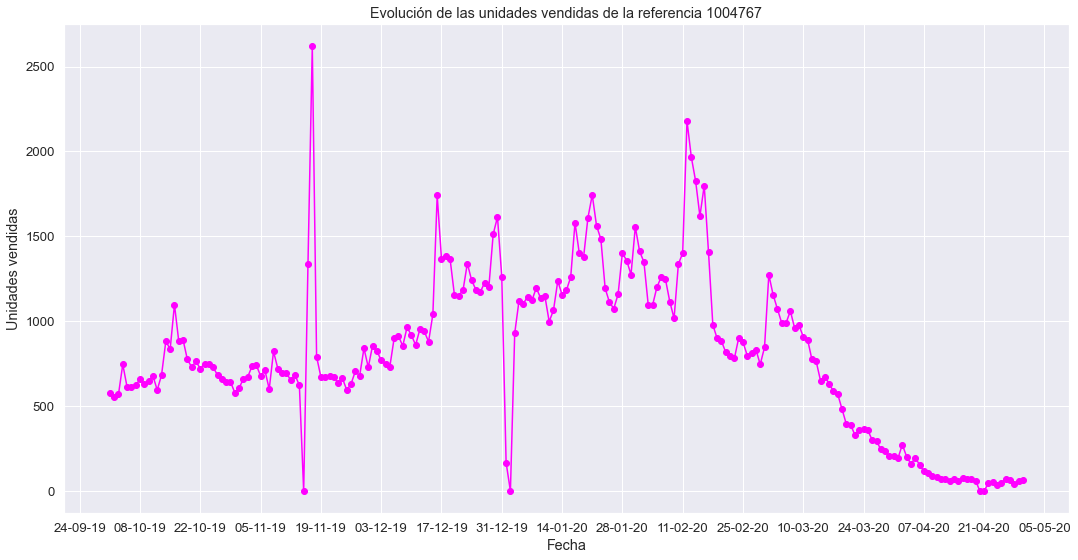

In [36]:
# Evolución de las ventas de una referencia a lo largo del periodo observado
# Referencia n.º 1004767
pd_sales_multistore_1004767 = pd_sales_multistore[pd_sales_multistore['product_id'] == 1004767].set_index('event_time')['user_session'] \
.resample('D').count().to_frame().reset_index()

sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(18, 9))
ax.plot(pd_sales_multistore_1004767['event_time'],
        pd_sales_multistore_1004767['user_session'],
        '-o',
        color='magenta')
ax.set(xlabel="Fecha", ylabel="Unidades vendidas",
       title="Evolución de las unidades vendidas de la referencia 1004767")

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

plt.show()

### 5.2 Marcas más vendidas

In [37]:
# Dataset ordenado por número de unidades vendidas por marca
pd_sales_multistore[['brand', 'user_session']].groupby(['brand']).count(). \
sort_values(by=['user_session'], ascending=False).rename(columns={'user_session': 'units_sold_per_brand'}).head(10)
# Comando alternativo
# _sales_multistore.value_counts(subset=['brand'])

,units_sold_per_brand
brand,
samsung,1527193
apple,1216172
xiaomi,506110
huawei,221154
oppo,116500
lg,87271
lucente,78721
sony,62378
acer,60265


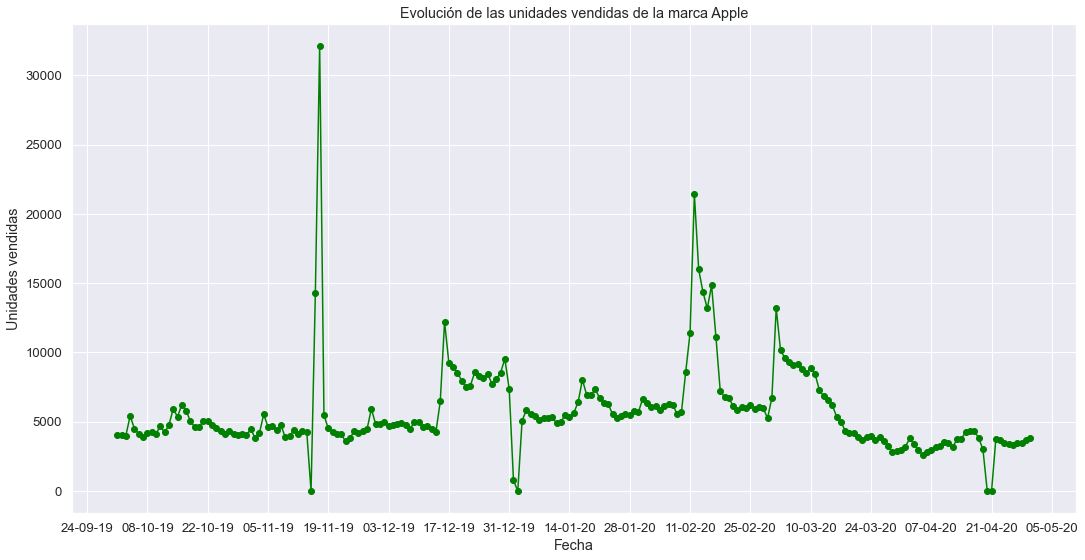

In [38]:
# Evolución de las ventas de una marca a lo largo del periodo observado
# Marca: Apple
pd_sales_multistore_apple = pd_sales_multistore[pd_sales_multistore['brand'] == 'apple'].set_index('event_time')['user_session'] \
.resample('D').count().to_frame().reset_index()

sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(18, 9))
ax.plot(pd_sales_multistore_apple['event_time'],
        pd_sales_multistore_apple['user_session'],
        '-o',
        color='green')
ax.set(xlabel="Fecha", ylabel="Unidades vendidas",
       title="Evolución de las unidades vendidas de la marca Apple")

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

plt.show()

### 5.3 Productos más vendidos, por marca

In [39]:
# Dataset ordenado por número de unidades vendidas por producto y marca marca
pd_sales_multistore[['product_id', 'brand', 'user_session']].groupby(['brand', 'product_id'], observed=True)['user_session'] \
.count().to_frame().sort_values(by=['brand', 'user_session'], ascending=[True, False]).rename(columns={'user_session': 'units_sold_per_prod_id_brand'}).head(100)

units_sold_per_prod_id_brand
brand  product_id                              
a-case 100014125                            332
       100014007                            231
       100118021                            164
       100118024                            134
       18001338                             126
...                                         ...
       18001415                               2
       18001574                               2
       100008067                              2
       100008106                              2
       100011802                              2

[100 rows x 1 columns]

### 5.4 Clientes más compradores (por número de referencias compradas en total)

In [40]:
# Dataset ordenado por número de unidades vendidas por cliente
ps_top_buyers_units = pd_sales_multistore[['user_id', 'user_session']].groupby(['user_id']).count(). \
sort_values(by=['user_session'], ascending=False).rename(columns={'user_session': 'best_buyers_per_units_sold'}).head(10)
# Comando alternativo
# pd_sales_multistore.value_counts(subset=['user_id'])
ps_top_buyers_units

,best_buyers_per_units_sold
user_id,
568782581,1974
549109608,1342
513230794,1340
513320236,1141
598224683,968
563599039,921
553431815,885
566448225,826
628167977,823


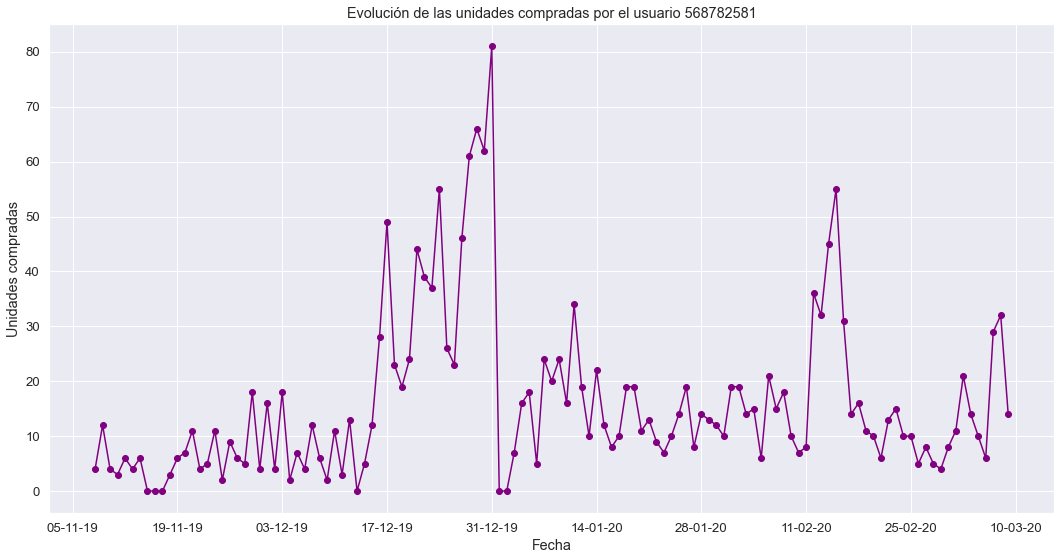

In [41]:
# Evolución de las ventas (por unidades) a los clientes más compradores a lo largo del periodo observado: cliente nº 568782581
pd_sales_multistore_568782581 = pd_sales_multistore[pd_sales_multistore['user_id'] == 568782581].set_index('event_time')['user_session'] \
.resample('D').count().to_frame().reset_index()

fig, ax = plt.subplots(figsize=(18, 9))
ax.plot(pd_sales_multistore_568782581['event_time'],
        pd_sales_multistore_568782581['user_session'],
        '-o',
        color='purple')
ax.set(xlabel="Fecha", ylabel="Unidades compradas",
       title="Evolución de las unidades compradas por el usuario 568782581")

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

plt.show()

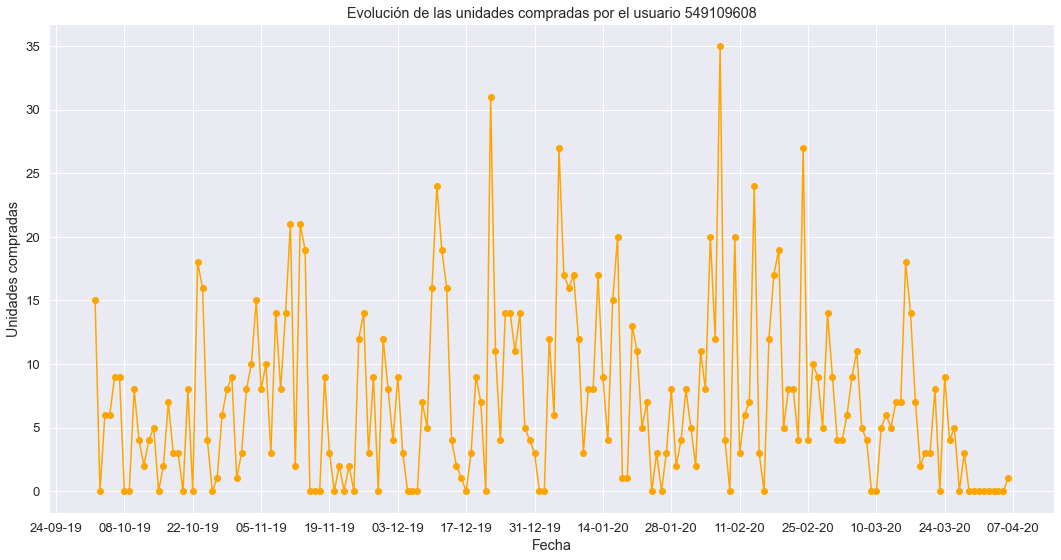

In [42]:
# Evolución de las ventas (por unidades) a los clientes más compradores a lo largo del periodo observado: cliente nº 549109608
pd_sales_multistore_549109608 = pd_sales_multistore[pd_sales_multistore['user_id'] == 549109608].set_index('event_time')['user_session'] \
.resample('D').count().to_frame().reset_index()

fig, ax = plt.subplots(figsize=(18, 9))
ax.plot(pd_sales_multistore_549109608['event_time'],
        pd_sales_multistore_549109608['user_session'],
        '-o',
        color='orange')
ax.set(xlabel="Fecha", ylabel="Unidades compradas",
       title="Evolución de las unidades compradas por el usuario 549109608")

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

plt.show()

### 5.5 Clientes más compradores (por el importe de compra)

In [43]:
# Dataset ordenado por número de unidades vendidas por cliente
pd_sales_multistore[['user_id', 'price']].groupby(['user_id']).sum(). \
sort_values(by=['price'], ascending=False).rename(columns={'price': 'best_buyers_total_sale'}).head(10)
# Comando alternativo
# pd_sales_multistore.value_counts(subset=['user_id'])
# ps_top_buyers_value

,best_buyers_total_sale
user_id,
553431815,788315.95
549109608,727569.03
569333570,675298.33
513230794,631763.40
595104624,601099.77
513320236,559629.79
568782581,513424.50
538216048,496900.03
598224683,484483.11


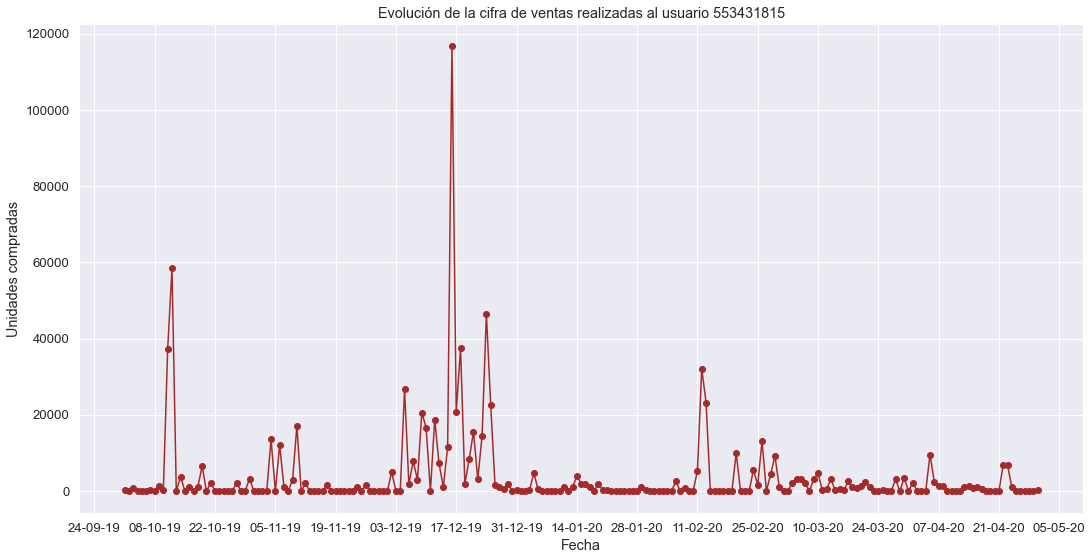

In [45]:
sns.set(font_scale=1.2)
# Evolución de las ventas (por importe) a los clientes más compradores a lo largo del periodo observado: cliente nº 553431815
pd_sales_multistore_553431815 = pd_sales_multistore[pd_sales_multistore['user_id'] == 553431815].set_index('event_time')['price'] \
.resample('D').sum().astype(float).to_frame().reset_index()

fig, ax = plt.subplots(figsize=(18, 9))
ax.plot(pd_sales_multistore_553431815['event_time'],
        pd_sales_multistore_553431815['price'],
        '-o',
        color='brown')
ax.set(xlabel="Fecha", ylabel="Unidades compradas",
       title="Evolución de la cifra de ventas realizadas al usuario 553431815",)
# fig.set(legend="Importe de venta")
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))
plt.show()

### 5.6 Días con más ventas

In [47]:
# Dataset con ventas en unidades agrupadas por día
pd_sales_multistore_total_units = pd_sales_multistore.set_index('event_time')['user_session'].resample('D'). \
count().sort_values(ascending=False).to_frame().rename(columns={'user_session': 'sales_on_a_day'})
pd_sales_multistore_total_units.head(10)

,sales_on_a_day
event_time,
2019-11-17 00:00:00+00:00,134718
2020-02-12 00:00:00+00:00,69357
2020-02-16 00:00:00+00:00,57731
2019-12-16 00:00:00+00:00,55518
2020-02-13 00:00:00+00:00,55500
2019-11-16 00:00:00+00:00,51205
2020-02-14 00:00:00+00:00,50602
2020-02-15 00:00:00+00:00,48278
2020-03-02 00:00:00+00:00,47147


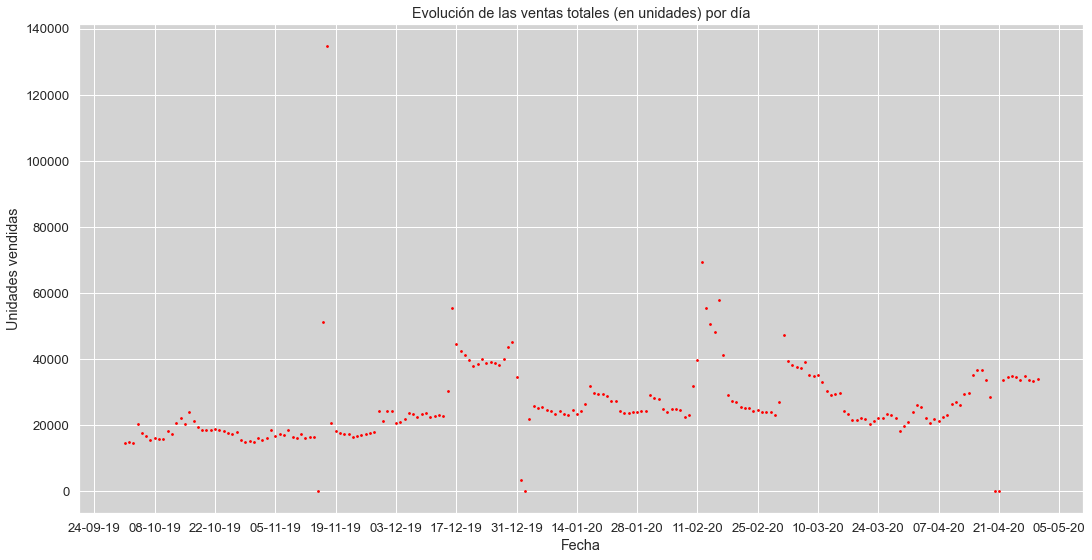

In [82]:
sns.set(rc={'axes.facecolor':'lightgrey'}, font_scale=1.2)

fig, ax = plt.subplots(figsize=(18, 9))
ax.scatter(pd_sales_multistore_total_units.index,
        pd_sales_multistore_total_units['sales_on_a_day'],
        s=3,
        marker='o',
        c=['red'])
# plt.yscale('log')
ax.set(xlabel="Fecha", ylabel="Unidades vendidas",
       title="Evolución de las ventas totales (en unidades) por día",)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))
plt.show()

Llama la atención que haya varios días de febrero con máximos de ventas: 12/02/2020, 13/02/2020, 14/02/2020, 15/02/2020, 16/02/2020. He estado investigando en que país podría haber algún tipo de celebración o semana especial de rebajas y lo más cercano que he encontrado es la Fiesta de la Primavera (Año Nuevo) en China.

### 5.7 "Customer behavior"

In [116]:
# Referencias compradas por el cliente más comprador durante una sesión
# Consulto primero la sesión en la que ha comprado más referencias
ps_customer_sales_553431815 = pd_sales_multistore[pd_sales_multistore['user_id'] == 553431815].groupby(['user_session']) \
['user_id'].count().to_frame().sort_values(by=['user_id'], ascending=False) \
.rename(columns={'user_id': 'bought_products'})
# .rename(columns={'user_session': 'best_buyers_per_units_sold'}).head(10)
ps_customer_sales_553431815

,bought_products
user_session,
75afc686-5967-4352-befe-378f7977abf4,46
a504c379-9d7e-40e4-8979-e5ff42251714,27
9474ffd0-a87d-475b-9181-f90d830d4c80,24
c04e8f89-1fa6-4c17-b185-e00e318c2a6f,19
f1a88c8f-bafa-46ba-897f-603f73b4f338,18
...,...
74374ad1-b22d-4660-9f73-0b2e0f8a3811,1
7486e466-8359-4bfe-a699-2e4a609f9695,1
762d75d4-6037-4bfb-becb-f09ac060ba42,1


In [117]:
# Probemos con la sesión n.º '75afc686-5967-4352-befe-378f7977abf4'.
ps_customer_behavior_553431815 = pd_sales_multistore[pd_sales_multistore['user_id'] == 553431815].reset_index()
ps_customer_behavior_553431815[ps_customer_behavior_553431815['user_session'] == '75afc686-5967-4352-befe-378f7977abf4'].sort_values(by='event_time')

,index,event_time,product_id,category_id,category_code,brand,price,user_id,user_session
366,1610513,2019-12-16 19:10:19+00:00,1005107,2232732093077520756,construction.tools.light,apple,1041.97,553431815,75afc686-5967-4352-befe-378f7977abf4
367,1610536,2019-12-16 19:11:04+00:00,1005107,2232732093077520756,construction.tools.light,apple,1041.97,553431815,75afc686-5967-4352-befe-378f7977abf4
368,1610551,2019-12-16 19:11:41+00:00,1005107,2232732093077520756,construction.tools.light,apple,1041.97,553431815,75afc686-5967-4352-befe-378f7977abf4
369,1610575,2019-12-16 19:12:28+00:00,1005107,2232732093077520756,construction.tools.light,apple,1041.97,553431815,75afc686-5967-4352-befe-378f7977abf4
370,1610598,2019-12-16 19:13:12+00:00,1005107,2232732093077520756,construction.tools.light,apple,1041.97,553431815,75afc686-5967-4352-befe-378f7977abf4
371,1610634,2019-12-16 19:14:26+00:00,1005107,2232732093077520756,construction.tools.light,apple,1041.97,553431815,75afc686-5967-4352-befe-378f7977abf4
372,1610653,2019-12-16 19:15:01+00:00,1005107,2232732093077520756,construction.tools.light,apple,1041.97,553431815,75afc686-5967-4352-befe-378f7977abf4
373,1610668,2019-12-16 19:15:35+00:00,1005107,2232732093077520756,construction.tools.light,apple,1041.97,553431815,75afc686-5967-4352-befe-378f7977abf4
374,1610684,2019-12-16 19:16:21+00:00,1005107,2232732093077520756,construction.tools.light,apple,1041.97,553431815,75afc686-5967-4352-befe-378f7977abf4
375,1610708,2019-12-16 19:17:05+00:00,1005107,2232732093077520756,construction.tools.light,apple,1041.97,553431815,75afc686-5967-4352-befe-378f7977abf4


Este ejemplo no permite deducir un patrón de compra del cliente, porque resulta que ha comprado **50 veces** la misma referencia en una misma sesión. Es bastante sospechoso, a menos que no se trate de un gran cliente que realiza compras masivas (algo, por otra parte, extraño en una web de e-commerce minorista).

## 6. Categoría "Smartphones"

In [76]:
df_smartphones = pd_sales_multistore.loc[pd_sales_multistore['category_code'] == 'electronics.smartphone', ['event_time', 'product_id', 'brand', 'price', 'user_id', 'user_session']]

In [77]:
df_smartphones.head(10)

,event_time,product_id,brand,price,user_id,user_session
0,2019-10-01 00:02:14+00:00,1004856,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564
1,2019-10-01 00:04:37+00:00,1002532,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68
5,2019-10-01 00:10:08+00:00,1002524,apple,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238
8,2019-10-01 00:14:14+00:00,1004932,vivo,463.31,555083442,83d12d1a-5452-4fa0-abbb-d9f492f8b562
9,2019-10-01 02:19:10+00:00,1004246,apple,736.18,515246296,b7dbae4f-cad3-463e-89ce-41990cf48dea
10,2019-10-01 02:19:34+00:00,1005104,apple,975.57,555160488,a1395546-c124-456c-9752-0f5cf883c63d
14,2019-10-01 02:20:33+00:00,1003316,apple,946.97,516198933,e1050ba4-5425-4b8e-9cc8-194878031718
15,2019-10-01 02:21:02+00:00,1004659,samsung,787.18,555168263,d068d08f-aaf3-4949-b031-cdaf49a5c7cf
17,2019-10-01 02:22:11+00:00,1004750,samsung,197.43,555110488,ce885079-4d92-4fe6-92a3-377c5a2d8291
21,2019-10-01 02:23:05+00:00,1004903,huawei,111.82,512812487,d3ef047f-9476-4b8d-a126-b483c55de653


In [78]:
df_smartphones.shape

(733214, 6)

### 6.1 Unidades vendidas de smartphones, por marca y referencia

In [79]:
df_smartphones_brands_products_count = df_smartphones.groupby(['brand', 'product_id'], observed=True)['user_session'] \
.count().to_frame().sort_values(by=['brand', 'user_session'], ascending=[True, False]) \
.rename(columns={'user_session': 'sales'})

In [80]:
df_smartphones_brands_products_count.head(15)

sales
brand  product_id       
a-case 18001428       25
       18001415        2
       18001340        1
       18001378        1
apple  1005115     34785
       1002544     22225
       1004249     17970
       1005105     15776
       1002524     12877
       1002633     10533
       1005135      7502
       1003306      7366
       1005116      7036
       1004258      5422
       1003317      5254

La guardo como csv, porque puede servir para el futuro.

In [81]:
df_smartphones_brands_products_count.to_csv('df_smartphones_brands_products_count.csv')

### 6.2 Lista de marcas (entre otras cosas para utilizarla en Google Trends)

In [82]:
df_smartphones_brands_products_count.index.unique(level='brand')

CategoricalIndex(['a-case', 'apple', 'asus', 'blackberry', 'bq', 'denzel',
                  'deppa', 'doogee', 'fly', 'gionee', 'goodloot', 'google',
                  'haier', 'hiper', 'honor', 'htc', 'huawei', 'inoi', 'irbis',
                  'iwalk', 'jinga', 'karya', 'kisswill', 'lego', 'lenovo',
                  'lg', 'meizu', 'micromax', 'nillkin', 'nokia', 'nubia',
                  'oneplus', 'oppo', 'petek', 'philips', 'prestigio', 'rapid',
                  'samsung', 'sony', 'takeit', 'tecno', 'texet', 'tp-link',
                  'umi', 'vega', 'vertex', 'vivo', 'x-level', 'xiaomi', 'zte'],
                 categories=['a-case', 'a-derma', 'a-elita', 'a-mega', 'a-toys', 'aardwolf', 'abaybooks', 'abc', ...], ordered=False, dtype='category', name='brand')

### 6.3 Evolución de las ventas (por unidades) de una marca concreta

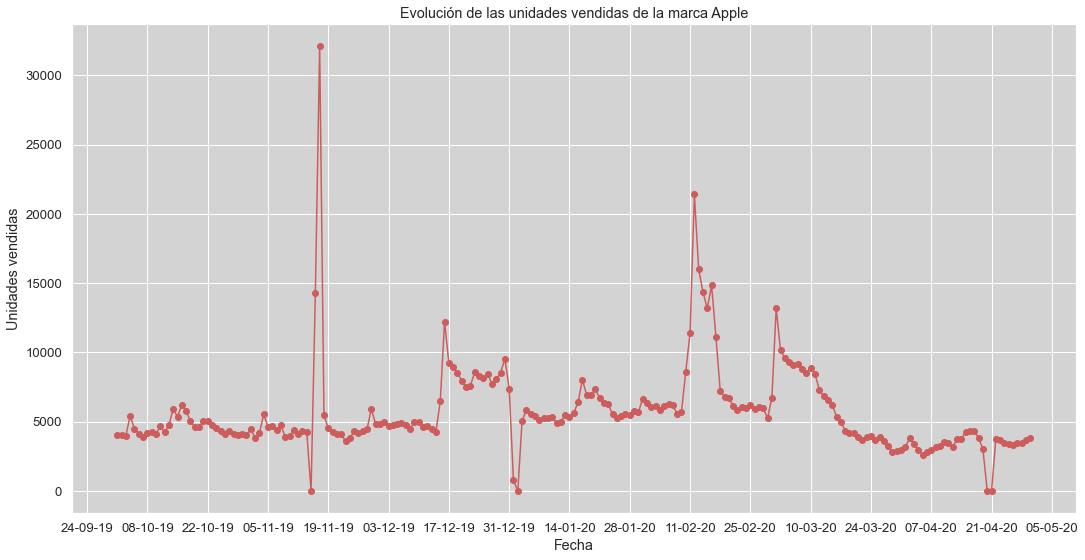

In [85]:
# Evolución de las ventas (por unidades) de una marca concreta a lo largo del periodo observado: marca Apple
pd_sales_multistore_apple = pd_sales_multistore[pd_sales_multistore['brand'] == 'apple'].set_index('event_time')['user_session'] \
.resample('D').count().to_frame().reset_index()

fig, ax = plt.subplots(figsize=(18, 9))
ax.plot(pd_sales_multistore_apple['event_time'],
        pd_sales_multistore_apple['user_session'],
        '-o',
        color='indianred')
ax.set(xlabel="Fecha", ylabel="Unidades vendidas",
       title="Evolución de las unidades vendidas de la marca Apple")

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

plt.show()

## X. Experimentos

In [31]:
# Agrego una columna con el número de unidades vendidas de la product_id
pd_sales_multistore['product_id_count'] = pd_sales_multistore['product_id'].map(pd_sales_multistore['product_id'].value_counts())

In [32]:
pd_sales_multistore.head()

,event_time,product_id,category_id,category_code,brand,price,user_id,user_session,product_id_count
0,2019-10-01 00:02:14+00:00,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,137999
1,2019-10-01 00:04:37+00:00,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,5966
2,2019-10-01 00:07:07+00:00,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,11
3,2019-10-01 00:09:26+00:00,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,33183
4,2019-10-01 00:09:54+00:00,4804056,2053013554658804075,electronics.audio.headphone,apple,161.98,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,119640


In [34]:
pd_sales_multistore.sort_values(by=['product_id_count'], ascending=False)

,event_time,product_id,category_id,category_code,brand,price,user_id,user_session,product_id_count
553132,2019-11-01 06:30:49+00:00,1004767,2053013555631882655,electronics.smartphone,samsung,242.48,557907552,af212783-36e7-4286-8801-efcbe43a2c52,172598
3602435,2020-02-16 08:24:35+00:00,1004767,2232732093077520756,construction.tools.light,samsung,230.12,606699457,cd415d2e-3ee6-4b9e-b8bf-effb4fec7ee9,172598
1798499,2019-12-21 10:02:34+00:00,1004767,2232732093077520756,construction.tools.light,samsung,244.08,530278581,27acb7f7-c87a-4487-b8b9-8b145f7c650d,172598
1798496,2019-12-21 10:02:29+00:00,1004767,2232732093077520756,construction.tools.light,samsung,244.08,550347248,029ad8c6-a035-4ecf-b0e5-e5fa0af4a46f,172598
153726,2019-10-10 10:04:16+00:00,1004767,2053013555631882655,electronics.smartphone,samsung,250.93,523291844,e73bccef-eaac-4391-9db4-99d4509913bd,172598
...,...,...,...,...,...,...,...,...,...
2713873,2020-01-22 06:51:33+00:00,100059107,2053013566142809077,construction.tools.generator,lara,24.78,516586482,f74c1cf6-bdd7-4a64-8145-30b48b4f78a8,1
3154969,2020-02-08 14:41:47+00:00,100109296,2232732102858637897,furniture.bedroom.blanket,rieker,73.88,544932246,9b507d78-667d-4982-bf46-a3a6823d74cc,1
5336784,2020-04-17 18:57:37+00:00,40500112,2232732100224614933,country_yard.cultivator,hoco,3.09,553485991,0fe279ed-17eb-4dbd-9734-6ba5f8e440fe,1
1531419,2019-12-15 06:02:09+00:00,34400002,2053013553853497655,apparel.jeans,leatherman,183.79,568397620,0a2c3a68-3343-474c-b9fb-6b9894c3b30c,1


In [15]:
pd_sales_multistore_brands = pd.DataFrame({'Product ID': pd_sales_multistore['product_id'],
                                           'Brand': pd_sales_multistore['brand']},)                                

In [16]:

pd_sales_multistore_brands['Referencias vendidas'] = pd_sales_multistore_brands.groupby('Product ID', as_index=False).transform(lambda s: s.count())

In [17]:
pd_sales_multistore_brands.groupby('Product ID').head(10)

,Product ID,Brand,Referencias vendidas
0,1004856,samsung,139666
1,1002532,apple,6043
2,13800054,santeri,11
3,4804055,apple,33990
4,4804056,apple,122056
...,...,...,...
5707888,15800011,karcher,29
5707910,100216253,decathlon,6
5707911,4200997,almacom,38
5707912,4802522,remax,2


In [18]:
# Equivalente a 
# pd_sales_multistore.value_counts(subset=['product_id'])
# If you have any categorical columns in your data (rather than categories stored as object columns or strings),
# make sure you use the observed=True option in your groupby command.
# This makes sure it only creates lines where an entry is present, e.g. only one line per customer_id,order_id combination,
# rather than creating n_custs * n_orders lines!
df_brands_products_count = pd_sales_multistore.groupby(['brand', 'product_id'], observed=True)['user_session'].count().to_frame()

In [19]:
df_brands_products_count.sort_values(by=['brand', 'user_session'], ascending=[True, False], inplace=True)

In [20]:
df_brands_products_count

user_session
brand  product_id              
a-case 100014125            342
       100014007            231
       100118021            164
       100118024            134
       18001338             128
...                         ...
zvezda 100023890              1
zyxel  7600021                2
       7600096                1
       7600139                1
       7600559                1

[96722 rows x 1 columns]

## X. read_csv modificado para convertir directamente los tipos de las columnas

In [ ]:
pd_sales_multistore = pd.read_csv('sales_multistore_10_2019_04_2020_v2.csv',
                 dtype={'product_id':'int32', 'category_id':'int64'}, 
                 converters={'price': D.Decimal})

## Dask - Una librería para hacer computaciones en paralelo

import dask.dataframe as dd

df = dd.from_pandas(df)

result = df.groupby('id').max().reset_index().compute()

All you need to do is convert your pandas.DataFrame into a dask.dataframe. Dask is a python out-of-core parallelization framework that offers various parallelized container types, one of which is the dataframe. It let's you perform most common pandas.DataFrame operations in parallel and/or distributed with data that is too large to fit in memory. The core of dask is a set of schedulers and an API for building computation graphs, hence we have to call .compute() at the end in order for any computation to actually take place. The library is easy to install because it is written in pure python for the most part.